**《深度学习之 PyTorch 实战》**

讲师作者：[土豆老师](https://iphysresearch.github.io)

# 线性回归

## 线性回归的矢量计算表达式

在模型训练或预测时，我们常常会同时处理多个数据样本并用到矢量计算。在介绍线性回归的矢量计算表达式之前，让我们先考虑对两个向量相加的两种方法。

In [1]:
import torch  # 加载 torch 库
torch.__version__   # 查看版本

'1.3.0.post2'

下面先定义两个1000维的向量。

In [2]:
from time import time

a = torch.ones(1000)
b = torch.ones(1000)

向量相加的一种方法是，将这两个向量按元素逐一做标量加法。

In [5]:
start = time()
c = torch.zeros(1000)
for i in range(1000):
    c[i] = a[i] + b[i]
time() - start

0.1520709991455078

向量相加的另一种方法是，将这两个向量直接做矢量加法。

In [6]:
start = time()
d = a + b
time() - start

0.00027632713317871094

结果很明显，后者比前者更省时。因此，我们应该尽可能采用矢量计算，以提升计算效率。

---

## 线性回归的从零开始实现
>(Restart your kernel here)

在了解了线性回归的背景知识之后，现在我们可以动手实现它了。尽管强大的深度学习框架可以减少大量重复性工作，但若过于依赖它提供的便利，会导致我们很难深入理解深度学习是如何工作的。因此，本节将介绍如何只利用 `Tensor` 和 `autograd` 来实现一个线性回归的训练。

In [1]:
import torch  # 加载 torch 库
print(torch.__version__)   # 查看版本

# matplotlib 包可用于作图，设置成嵌入显示 (jupyter 中的魔法指令)
%matplotlib inline  
from IPython import display
from matplotlib import pyplot as plt 
import random

1.3.0.post2


### 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为 1000，输入个数（特征数）为 2。给定随机生成的批量样本特征 $\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重 $\boldsymbol{w} = [2, -3.4]^\top$ 和偏差 $b=4.2$，以及一个随机噪声项 $\epsilon$ 来生成标签

$$\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon,$$

其中噪声项 $\epsilon$ 服从均值为 0、标准差为 0.01 的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [2]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features = torch.normal(mean=0, std=1, size=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.normal(mean=0, std=0.01, size=labels.shape)

print('X:',features.shape, 'y:', labels.shape)

X: torch.Size([1000, 2]) y: torch.Size([1000])


注意，`features` 的每一行是一个长度为 2 的向量，而 `labels` 的每一行是一个长度为 1 的向量（标量）。

In [3]:
features[0], labels[0]

(tensor([0.1915, 0.4583]), tensor(3.0206))

通过生成第二个特征 `features[:, 1]` (矩阵的第二列) 和标签 `labels` 的散点图，可以更直观地观察两者间的线性关系。

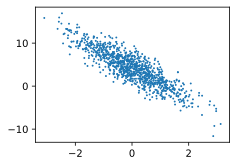

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);  # 加分号只显示图

我们将上面的 `plt` 作图函数以及 `use_svg_display` 函数和 `set_figsize` 函数定义在 `dl4wm` 包里。以后在作图时，我们将直接调用 `dl4wm.plt`。由于 `plt` 在 `dl4wm` 包中是一个全局变量，我们在作图前只需要调用 `dl4wm.set_figsize()` 即可打印矢量图并设置图的尺寸。

### 读取数据集

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回 `batch_size`（批量大小）个随机样本的特征和标签。

In [11]:
# 本函数已保存在 dl4wm 包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(dim=0, index=j), labels.index_select(dim=0, index=j) 
        # index_select 函数根据索引返回对应元素

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为 (10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [12]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X)
    print(y)
    break

tensor([[ 0.8558,  1.7363],
        [ 0.2204, -1.5585],
        [ 0.2168, -0.2810],
        [-0.3010, -0.2693],
        [ 0.0926,  0.7364],
        [-1.3542,  0.9348],
        [ 0.1820, -1.4468],
        [-0.8049,  0.4269],
        [-0.2008, -0.4136],
        [-0.1879,  0.1783]])
tensor([ 1.4626e-03,  9.9292e+00,  5.5806e+00,  4.5016e+00,  1.8871e+00,
        -1.6775e+00,  9.4821e+00,  1.1425e+00,  5.2125e+00,  3.1927e+00])


### 初始化模型参数

我们将权重初始化成均值为 0、标准差为 0.01 的正态随机数，偏差则初始化成 0。

In [13]:
w = torch.normal(mean=0, std=0.01, size=(num_inputs, 1))
b = torch.zeros(size=(1,))
assert w.dtype == torch.float32

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们需要创建它们的梯度。

In [14]:
# w.requires_grad = True
# b.requires_grad = True
# or
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True);

### 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用 `torch.mm` 函数做矩阵乘法。

$$
\hat{\boldsymbol{y}}=\boldsymbol{X} \boldsymbol{w}+b
$$

In [16]:
def linreg(X, w, b):  # 本函数已保存在 dl4wm 包中方便以后使用
    return torch.mm(X, w) + b

### 定义损失函数

我们使用刚刚描述的**平方损失**来定义线性回归的损失函数。在实现中，我们需要把真实值 `y` 变形成预测值 `y_hat` 的形状。以下函数返回的结果也将和 `y_hat` 的形状相同。

$$
\ell^{(i)}\left(w_{1}, w_{2}, b\right)=\frac{1}{2}\left(\hat{y}^{(i)}-y^{(i)}\right)^{2}
$$

In [17]:
def squared_loss(y_hat, y):  # 本函数已保存在 dl4wm 包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch 里的 MSELoss 并没有除以 2
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法

以下的 `sgd` 函数实现了上一节中介绍的**小批量随机梯度下降算法**。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

$$
\begin{array}{l}
w_{1} \leftarrow w_{1}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac{\partial \ell^{(i)}\left(w_{1}, w_{2}, b\right)}{\partial w_{1}} \\
w_{2} \leftarrow w_{2}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac{\partial \ell^{(i)}\left(w_{1}, w_{2}, b\right)}{\partial w_{2}} \\
b \leftarrow b-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac{\partial \ell^{(i)}\left(w_{1}, w_{2}, b\right)}{\partial b}
\end{array}
$$

In [18]:
def sgd(params, lr, batch_size):  # 本函数已保存在 dl4wm 包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更新的是 param.data ！

- Why `param.data`？
    - 上面的计算对 `param.data` 值的更改，并不会记录在计算图里，所以不会影响到梯度的计算。
    - 但是，对 `param.data` 值的更改，依然会影响原 `param` 的值。

### 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征 `X` 和标签 `y`），通过调用反向函数 `backward` 计算小批量随机梯度，并调用优化算法 `sgd` 迭代模型参数。由于我们之前设批量大小 `batch_size` 为 10，每个小批量的损失 `l` 的形状为 (10, 1)。回忆一下上一讲中谈到“自动求梯度”的时候。由于变量 `l` 并不是一个标量，所以我们将会运行 `torch.mean` 函数 (`torch.sum`也可以) 将其约化到一个标量，再运行 `l.backward()` 将对 `l` 中元素求和得到新的变量，再求该变量有关模型参数的梯度。

在一个**迭代周期**（epoch）中，我们将完整遍历一遍 `data_iter` 函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数 `num_epochs` 和学习率 `lr` 都是超参数，分别设 10 和 0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。我们会在后面“优化算法”的课程中再详细介绍学习率对模型的影响。

In [21]:
lr = 0.03           # 学习率
num_epochs = 10      # 迭代周期个数
net = linreg         # 我们的线性回归模型
loss = squared_loss  # 损失函数 0.5 (y-y')^2

for epoch in range(num_epochs):  # 训练模型一共需要 num_epochs 个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。
    # X 和 y 分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # l是有关小批量 X 和 y 的损失
        l.mean().backward()  # 小批量的损失 l 对模型参数 [w, b] 求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 一定不要忘了对当前小批量数据下的梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    with torch.no_grad():
        train_l = sum([loss(net(X, w, b),y).mean() for X, y in data_iter(batch_size, features, labels)])/num_examples
        print('epoch %d, loss %f' % (epoch + 1, train_l))


epoch 1, loss 0.001948
epoch 2, loss 0.001056
epoch 3, loss 0.000573
epoch 4, loss 0.000313
epoch 5, loss 0.000172
epoch 6, loss 0.000095
epoch 7, loss 0.000054
epoch 8, loss 0.000032
epoch 9, loss 0.000020
epoch 10, loss 0.000013


训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。

In [22]:
print('Error in estimating w', true_w - w.reshape(true_w.shape).data)
print('Error in estimating b', true_b - b.data)
print('='*50, '\nTrue w:{}\nPred w:{}'.format(true_w.numpy(),
                                                w.reshape(true_w.shape).data.numpy()))
print('='*50, '\nTrue b:{}\nPred b:{}'.format(true_b,
                                                b.data.numpy()))

Error in estimating w tensor([ 0.0053, -0.0058])
Error in estimating b tensor([0.0090])
True w:[ 2.  -3.4]
Pred w:[ 1.9946705 -3.3942113]
True b:4.2
Pred b:[4.1910048]


>注意：`grad` 在反向传播过程中是**累加的**(accumulated, `+=`)，这意味着每一次运行反向传播，梯度都会累加之前的梯度，所以一般在反向传播之前需把梯度清零。

In [32]:
w.grad.data.zero_()

l = loss(net(X, w, b), y)  # l是有关小批量 X 和 y 的损失
l.mean().backward()  # 小批量的损失 l 对模型参数 [w, b] 求梯度
w.grad

tensor([[-0.0015],
        [-0.0026]])

In [24]:
w.grad

tensor([[-0.0015],
        [-0.0026]])

小结：

- 仅使用 `Tensor` 和 `autograd` 模块就可以很容易地实现一个模型。

- 更加紧凑的写法：

```python
def sgd(params, lr, batch_size):
    for param in params:
        param.data.sub_(lr*param.grad/batch_size)
        param.grad.data.zero_()
```

---

## 线性回归的简洁实现

>(Restart your kernel here)

随着深度学习框架的发展，开发深度学习应用变得越来越便利。实践中，我们通常可以用比上一节更简洁的代码来实现同样的模型。在本节中，我们将介绍如何使用 PyTorch 更方便地实现线性回归的训练。

In [1]:
import torch  # 加载 torch 库
print(torch.__version__)   # 查看版本
import numpy as np

1.3.0.post2


### 生成数据集

我们生成与上一节中相同的数据集。其中 `features` 是训练数据特征，`labels` 是标签。

In [2]:
def synthetic_data(w, b, num_examples):
    """generate y = X w + b + noise"""
    X = np.random.normal(scale=1, size=(num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(scale=0.01, size=y.shape)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float().reshape(-1,1)
    return X,y

true_w = torch.Tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features.size(), labels.size()

(torch.Size([1000, 2]), torch.Size([1000, 1]))

### 读取数据

PyTorch 提供了 `data` 包来读取数据。由于 `data` 常用作变量名，我们将导入的 `data` 模块用 `Data` 代替。在每一次迭代中，我们将随机读取包含 10 个数据样本的小批量。

In [4]:
import torch.utils.data as Data
def load_array(data_arrays, batch_size, is_train=True):
    # 将训练数据的特征和标签组合
    dataset = Data.TensorDataset(*data_arrays)
    # 随机读取小批量
    dataloader = Data.DataLoader(dataset, batch_size, shuffle=True)
    return dataloader

batch_size = 10
data_iter = load_array((features, labels), batch_size)

这里 `data_iter` 的使用跟上一节中的一样。让我们读取并打印第一个小批量数据样本。

In [13]:
for X, y in data_iter:
    print(X)
    print(y)
    break

tensor([[ 1.5651,  0.7536],
        [-0.7829, -1.6684],
        [-0.8139,  0.1182],
        [-0.4684,  0.5977],
        [ 1.2983,  0.8152],
        [ 1.0206, -0.7925],
        [-0.4237, -0.7368],
        [ 1.8887,  1.1557],
        [ 0.3605, -1.9125],
        [-0.8984,  0.1105]])
tensor([[ 4.7748],
        [ 8.3099],
        [ 2.1485],
        [ 1.2490],
        [ 4.0374],
        [ 8.9397],
        [ 5.8601],
        [ 4.0516],
        [11.4209],
        [ 2.0148]])


### 定义模型

在上一节从零开始的实现中，我们需要定义模型参数，并使用它们一步步描述模型是怎样计算的。当模型结构变得更复杂时，这些步骤将变得更繁琐。其实，PyTorch 提供了大量预定义的层，这使我们只需关注使用哪些层来构造模型。下面将介绍如何使用 PyTorch 更简洁地定义线性回归。

![](https://vip2.loli.io/2021/03/08/kHJDwS7tgOLeKan.png)

首先，导入 `torch.nn` 模块。实际上，"nn" 是 neural networks（神经网络）的缩写。顾名思义，该模块定义了大量神经网络的层。之前我们已经用过了 `autograd`，而 `nn` 就是利用 `autograd` 来定义模型。`nn` 的核心数据结构是 `Module`，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承 `nn.Module`，撰写自己的网络/层。一个 `nn.Module` 实例应该包含一些层以及返回输出的前向传播（forward）方法。下面先来看看如何用 `nn.Module` 实现一个线性回归模型。

In [25]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearRegressionModel, self).__init__()
        self.layer1 = torch.nn.Linear(in_features, out_features, bias=True)
    # forward 定义前向传播
    def forward(self, x):
        y = self.layer1(x)
        return y

net = LinearRegressionModel(in_features=2, out_features=1)
print(net) # 使用 print 可以打印出网络的结构

LinearRegressionModel(
  (layer1): Linear(in_features=2, out_features=1, bias=True)
)


另外，事实上我们还可以用 `nn.Sequential` 来更加方便地搭建网络，`Sequential` 是一个有序的容器，网络层将按照在传入 `Sequential` 的顺序依次被添加到计算图中。

其他写法：

In [23]:
# 写法一（参数化）
net = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
    # 此处还可以传入其他层
    )

# 写法二 (面向对象编程)
net = torch.nn.Sequential()
net.add_module('linear', torch.nn.Linear(2, 1))
# net.add_module ......

# 写法三（有序迭代化）
from collections import OrderedDict
net = torch.nn.Sequential(OrderedDict(
    [
        ('linear', torch.nn.Linear(2, 1)),
        # ......
    ]
))
print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


我们的模型定义好以后，就可以通过 `net.parameters()` 来查看模型所有的可学习参数，此函数将返回一个生成器。

In [17]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.3155, 0.2245]], requires_grad=True)
Parameter containing:
tensor([0.3160], requires_grad=True)


>回忆：线性回归在神经网络图中的表示。作为一个单层神经网络，线性回归输出层中的神经元和输入层中各个输入完全连接。因此，线性回归的输出层又叫全连接层。

>注意：`torch.nn` 仅支持输入一个 `batch` 的样本不支持单个样本输入，如果只有单个样本，可使用 `input.unsqueeze(0)` 来添加一维。

### 初始化模型参数

在使用 `net` 前，我们需要初始化模型参数，如线性回归模型中的权重和偏差。PyTorch 在 `init` 模块中提供了多种参数初始化方法。这里的 `init` 是 `initializer` 的缩写形式。我们通过 `init.normal_` 将权重参数每个元素初始化为随机采样于均值为 0、标准差为 0.01 的正态分布。偏差会初始化为零。

In [21]:
# 自定义方法
net.layer1.weight.data = torch.normal(mean=0,std=0.01,size=(1,2))
net.layer1.bias.data = torch.Tensor([0])

print(net.layer1.weight, net.layer1.bias)

Parameter containing:
tensor([[-0.0177,  0.0017]], requires_grad=True) Parameter containing:
tensor([0.], requires_grad=True)


In [24]:
# 方法一、二、三 
torch.nn.init.normal_(net[0].weight, mean=0, std=0.01)
torch.nn.init.constant_(net[0].bias, val=0)  
# 也可以直接修改 bias 的data: net[0].bias.data.fill_(0)

print(net[0].weight, net[0].bias)

Parameter containing:
tensor([[0.0150, 0.0002]], requires_grad=True) Parameter containing:
tensor([0.], requires_grad=True)


>注意：由于 `net[0]` 这样根据**下标**访问子模块的写法只有当 `net` 是个 `ModuleList` 或者 `Sequential` 实例时才可以。

### 定义损失函数

PyTorch 在 `nn` 模块中提供了各种损失函数，这些损失函数可看作是一种特殊的层，
PyTorch 也将这些损失函数实现为 `nn.Module` 的子类。我们现在使用它提供的均方误差损失作为模型的损失函数。

In [26]:
# Mean Squared Error (squared L2 norm) 
loss = torch.nn.MSELoss(reduction='mean')

The unreduced (i.e. with `reduction` set to ``'none'``) loss can be described as:

$$
    \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = \left( x_n - y_n \right)^2,
$$

where $N$ is the batch size. If `reduction` is not ``'none'``
(default ``'mean'``), then:

$$
    \ell(x, y) =
    \begin{cases}
        \operatorname{mean}(L), &  \text{if reduction} = \text{'mean';}\\
        \operatorname{sum}(L),  &  \text{if reduction} = \text{'sum'.}
    \end{cases}
$$

$x$ and $y$ are tensors of arbitrary shapes with a total
of $n$ elements each.

### 定义优化算法

同样，我们也无须自己实现小批量随机梯度下降算法。`torch.optim` 模块提供了很多常用的优化算法比如 SGD、Adam 和 RMSProp 等。下面我们创建一个用于优化 `net` 所有参数的优化器实例，并指定学习率为 0.03 的小批量随机梯度下降（SGD）为优化算法。

In [27]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


我们还可以为不同子网络设置不同的学习率，这在 **finetune** 时经常用到。例：

```python
optimizer =optim.SGD([
    # 如果对某个参数不指定学习率，就使用最外层的默认学习率
    {'params': net.subnet1.parameters()}, # lr=0.03
    {'params': net.subnet2.parameters(), 'lr': 0.01}
], lr=0.03)
```

有时候我们不想让学习率固定成一个常数，那如何调整学习率呢？主要有两种做法。一种是修改 `optimizer.param_groups` 中对应的学习率，另一种是更简单也是较为推荐的做法——新建优化器，由于 optimizer 十分轻量级，构建开销很小，故而可以构建新的 optimizer。但是后者对于使用动量的优化器（如 Adam），会丢失动量等状态信息，可能会造成损失函数的收敛出现震荡等情况。

```python
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍
```

关于学习的策略，我们会在之后的课程中给大家详细再谈到。

### 训练模型

在使用 PyTorch 训练模型时，我们通过调用 `optim` 实例的 `step` 函数来迭代模型参数。按照小批量随机梯度下降的定义，我们在 `step` 函数中指明批量大小，从而对批量中样本梯度求平均。

In [28]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于 net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000347
epoch 2, loss: 0.000121
epoch 3, loss: 0.000083


下面我们分别比较学到的模型参数和真实的模型参数。我们从 `net` 获得需要的层，并访问其权重（weight）和偏差（bias）。学到的参数和真实的参数很接近。

In [29]:
w = list(net.parameters())[0][0]
print('Error in estimating w', true_w.reshape(w.shape) - w)
b = list(net.parameters())[1][0]
print('Error in estimating b', true_b - b)

print('='*50, '\nTrue w:{}\nPred w:{}'.format(true_w.numpy(),
                                                w.reshape(true_w.shape).data.numpy()))
print('='*50, '\nTrue b:{}\nPred b:{}'.format(true_b,
                                                b.data.numpy()))

Error in estimating w tensor([-3.4595e-04, -4.8399e-05], grad_fn=<SubBackward0>)
Error in estimating b tensor(-0.0009, grad_fn=<RsubBackward1>)
True w:[ 2.  -3.4]
Pred w:[ 2.000346  -3.3999517]
True b:4.2
Pred b:4.200947284698486


>验证一下这个 `torch.nn.MSELoss` 和我们自己自定义的损失函数是不是真的差 1/2 呢？

In [32]:
loss(output, y.view(-1, 1))

tensor(8.3274e-05, grad_fn=<MseLossBackward>)

In [34]:
from dl4wm import squared_loss
squared_loss(output, y.view(-1, 1)).mean()*2

tensor(8.3274e-05, grad_fn=<MulBackward0>)

小结：

- `torch.utils.data` 模块提供了有关数据处理的工具，
- `torch.nn` 模块定义了大量神经网络的层
- `torch.nn.init` 模块定义了各种初始化方法
- `torch.optim` 模块提供了很多常用的优化算法。